In [1]:
from pymonntorch import Network, NeuronGroup, Recorder, EventRecorder, Behavior
from matplotlib import pyplot as plt
import torch, math, random, time, sympy, os, sys, pandas

""" Set the random seed for reproducibility """
torch.manual_seed(time.time());

In [2]:
class TimeResolution(Behavior):
    def initialize(self, network : Network) -> None:
        network.dt = self.parameter("dt", default = 0.1)

class Current(Behavior):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        """ Initialize the current """
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        
        neuron_G.I = neuron_G.vector(mode = self.init_current)

    def forward(self, neuron_G : NeuronGroup) -> None:
        """ Update the current according to the given function F """
        def eval_F() -> NeuronGroup.vector:
            """ Not tested. Not used. """
            return sympy.lambdify(sympy.symbols(list(self.vars.keys())), self.F)(*list(self.vars.values()))
        
        """ Different options for the current function F """
        if   self.F == "constant"   : neuron_G.I.fill_(self.init_current)
        elif self.F == "sin"        : neuron_G.I.fill_(self.init_current + self.amplitude * math.sin(2 * math.pi * self.frequency * neuron_G.network.iteration * neuron_G.network.dt + self.phase))
        elif self.F == "noise"      : neuron_G.I += random.gauss(self.mean, self.std)
        elif self.F == "train_pulse": neuron_G.I.fill_(self.init_current + self.amplitude) if neuron_G.network.iteration * neuron_G.network.dt % self.period == 0 else neuron_G.I.fill_(self.init_current)
        elif self.F == "step"       : neuron_G.I.fill_(self.init_current + self.amplitude) if self.t0 < neuron_G.network.iteration * neuron_G.network.dt < self.t1 else neuron_G.I.fill_(self.init_current)

In [3]:
class LIF(Behavior):
    # neuron_G.U = torch.where(neuron_G.REFRACTORY == 0, neuron_G.U + currents / self.tau * neuron_G.network.dt, neuron_G.U)

    def initialize(self, neuron_G : NeuronGroup) -> None:
        """ Initialize the LIF neuron. This is the rationale for different variants of LIF models. """
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        
        neuron_G.SPIKECNT = neuron_G.vector(mode = 0)
        neuron_G.THRESHOLD = neuron_G.vector(mode = self.threshold)
        neuron_G.U = neuron_G.vector(mode = self.u_init)
        neuron_G.REFRACTORY = neuron_G.vector(mode = 0)
        neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
        
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()
        neuron_G.U[neuron_G.SPIKE] = self.u_reset
        neuron_G.REFRACTORY[neuron_G.SPIKE] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0

    def forward(self, neuron_G : NeuronGroup) -> None:
        """ Update the membrane potential U of the LIF neuron. """
        leakage = -(neuron_G.U - self.u_rest)
        currents = self.R * neuron_G.I

        """ Simulate the refractoriness according to the given parameter refractoryMODE """
        if self.refractoryON and self.refractoryMODE == "BLOCK_CURRENT":
            neuron_G.U += leakage / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        elif self.refractoryON and self.refractoryMODE == "ADAPTIVE_THRESHOLD":
            neuron_G.U += (leakage) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
            neuron_G.THRESHOLD += (-(neuron_G.THRESHOLD - self.theta0) + self.theta * neuron_G.SPIKE.float()) / self.tau_a * neuron_G.network.dt
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        else:
            neuron_G.U += (leakage + currents) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        neuron_G.REFRACTORY[neuron_G.SPIKE.logical_or(neuron_G.REFRACTORY > 0)] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()

class ELIF(LIF):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        super().initialize(neuron_G)

    def forward(self, neuron_G : NeuronGroup) -> None:
        leakage = -(neuron_G.U - self.u_rest)
        currents = self.R * neuron_G.I

        if self.refractoryON and self.refractoryMODE == "BLOCK_CURRENT":
            neuron_G.U += (leakage + self.deltaT * torch.exp((neuron_G.U - self.u_rest) / self.deltaT)) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        elif self.refractoryON and self.refractoryMODE == "ADAPTIVE_THRESHOLD":
            neuron_G.U += (leakage + self.deltaT * torch.exp((neuron_G.U - self.u_rest) / self.deltaT)) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.THRESHOLD += (-(neuron_G.THRESHOLD - self.theta0) + self.theta * neuron_G.SPIKE.float()) / self.tau_a * neuron_G.network.dt
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        else:
            neuron_G.U += (leakage + currents + self.deltaT * torch.exp((neuron_G.U - self.u_rest) / self.deltaT)) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        neuron_G.REFRACTORY[neuron_G.SPIKE.logical_or(neuron_G.REFRACTORY > 0)] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()

class AELIF(ELIF):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        super().initialize(neuron_G)
        neuron_G.W = neuron_G.vector(mode = 0)

    def forward(self, neuron_G : NeuronGroup) -> None:
        leakage = -(neuron_G.U - self.u_rest)
        currents = self.R * neuron_G.I

        neuron_G.W += (self.a * (neuron_G.U - self.u_rest) - neuron_G.W + self.b * self.tau_w * neuron_G.SPIKE.float()) / self.tau_w * neuron_G.network.dt
        if self.refractoryON and self.refractoryMODE == "BLOCK_CURRENT":
            neuron_G.U += (leakage + self.deltaT * torch.exp((neuron_G.U - self.theta_rh) / self.deltaT) - neuron_G.W * self.R) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += (currents) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        elif self.refractoryON and self.refractoryMODE == "ADAPTIVE_THRESHOLD":
            neuron_G.THRESHOLD += (-(neuron_G.THRESHOLD - self.theta0) + self.theta * neuron_G.SPIKE.float()) / self.tau_a
            neuron_G.U += (leakage + currents + self.deltaT * torch.exp((neuron_G.U - self.theta_rh) / self.deltaT) - neuron_G.W * self.R) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        else:
            neuron_G.U += (leakage + currents + self.deltaT * torch.exp((neuron_G.U - self.theta_rh) / self.deltaT) - neuron_G.W * self.R) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        neuron_G.REFRACTORY[neuron_G.SPIKE or neuron_G.REFRACTORY > 0] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()

In [4]:
def FI(current_values : list) -> None:
    def calculate_frequency(network : Network, neuron_G : NeuronGroup, iteration_cnt : int) -> NeuronGroup.vector:
        return neuron_G.SPIKECNT / (network.dt * iteration_cnt)
    
    iteration = 600
    neuron_cnt = 1
    frequencies = []
    for c in current_values: 
        I_constant_params = { 
            "F" : "constant",
            "init_current" : c, 
        }; I_constant = Current(params = I_constant_params)

        I_noise_parmas = {
            "F" : "noise",
            "init_current" : c,
            "mean" : 0,
            "std" : 2,
        }; I_noise = Current(params = I_noise_parmas)

        lif_params = {
            "u_rest" : -80,
            "u_reset" : -90,
            "u_init" : -70,
            "tau" : 10,
            "R" : 1,
            "threshold" : -55,
            "refractoryON" : True,
            "refractoryMODE" : "ADAPTIVE_THRESHOLD",
            "theta0" : -30,
            "theta" : 10,
            "tau_a" : 200,
            "refractory_T" : 3
        }; lif_ = LIF(params = lif_params)

        I = I_constant

        behavior = {
            2 : I,
            3 : lif_,
            9 : Recorder(["U", "I"]),
            10: EventRecorder("SPIKE")
        }
        
        net = Network(behavior = {1 : TimeResolution(dt = 0.1)}, dtype = torch.float64)
        ng = NeuronGroup(size = neuron_cnt, net = net, tag = "NG_TEST", behavior = behavior)

        net.initialize()
        net.simulate_iterations(iteration)

        plt.plot(net["U", 0][:, :])
        plt.show()

        frequencies.append(calculate_frequency(network = net, neuron_G = ng, iteration_cnt = iteration))

    for i in range(neuron_cnt):
        frequency = [f[i].item() for f in frequencies]
        plt.scatter(current_values, frequency, color = 'darkgoldenrod')
        plt.plot(current_values, frequency, color = 'darkgoldenrod')
    # set x and y labels
    plt.xlabel('Current (I)', fontsize = 14)
    plt.ylabel('Frequency', fontsize = 14)
    # set face color
    
    plt.show()

#FI([c for c in range(0, 200, 10)])

In [6]:

lif_params = {
    "u_rest" : -80,
    "u_reset" : -90,
    "u_init" : -85,
    "tau" : 10,
    "R" : 1,
    "threshold" : -55,
    "refractoryON" : False,
    "refractoryMODE" : "ADAPTIVE_THRESHOLD",
    "theta0" : -30,
    "theta" : 10,
    "tau_a" : 200,
    "refractory_T" : 1
}; lif_ = LIF(params = lif_params)

elif_params = {
    "u_rest" : -80,
    "u_reset" : -90,
    "u_init" : -85,
    "tau" : 10,
    "R" : 1,
    "threshold" : -55,
    "refractoryON" : True,
    "refractoryMODE" : "BLOCK_CURRENT",
    "refractory_T" : 1,
    "deltaT" : 1,
    "theta0" : -70,
    "theta" : 20,
    "tau_a" : 1
}; elif_ = ELIF(params = elif_params)

I_constant_params = { 
        "F" : "constant",
        "init_current" : random.uniform(20, 100)
}; I_constant = Current(params = I_constant_params)
I = I_constant

aelif_params = {
    "u_rest" : random.uniform(-80, -70),
    "u_reset" : random.uniform(-90, -80),
    "u_init" : random.uniform(-80, -70),
    "tau" : random.uniform(0.5, 20),
    "R" : random.uniform(0.5, 2),
    "threshold" : random.uniform(-60, -50),
    "refractoryON" : True,
    "refractoryMODE" : "BLOCK_CURRENT",
    "refractory_T" : random.uniform(0, 5),
    "deltaT" : random.uniform(0.5, 5),
    "a" : random.uniform(1, 200),
    "b" : random.uniform(1, 200),
    "tau_w" : random.uniform(0.1, 200),
    "theta_rh" : -70,
}; aelif_ = AELIF(params = aelif_params)

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution(dt=0.1,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:Current(params={'F': 'constant', 'init_current': 72.02380013855041},)3:AELIF(params={'u_rest': -78.13648112697338, 'u_reset': -84.10825718773961, 'u_init': -72.09642646587723, 'tau': 17.615857576866983, 'R': 0.8704734048453723, 'threshold': -57.913367817758065, 'refractoryON': True, 'refractoryMODE': 'BLOCK_CURRENT', 'refractory_T': 0.1544039239252376, 'deltaT': 2.337259556332594, 'a': 174.86771805855767, 'b': 39.84544772833704, 'tau_w': 152.41823941883996, 'theta_rh': -70},)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['U', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=SPIKE,)}
1000xBatch: 1/1 (100%) 438.641ms


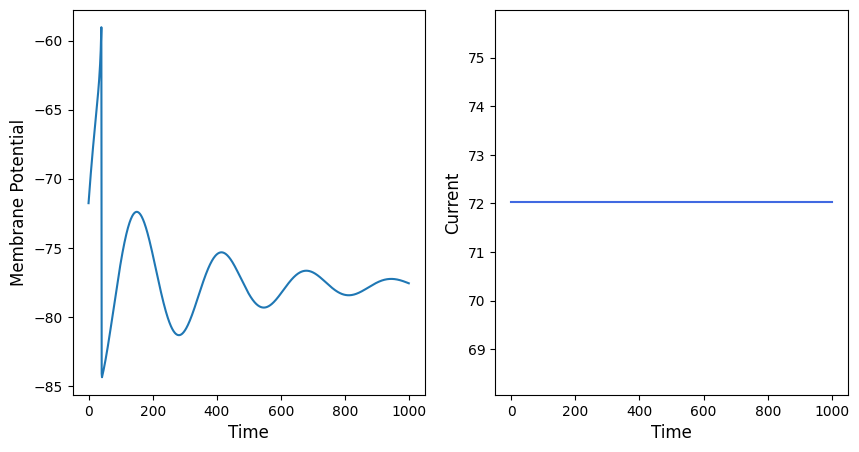

In [7]:

behavior = {
    2 : I,
    3 : aelif_,
    9 : Recorder(["U", "I"]),
    10: EventRecorder("SPIKE")
}

network      = Network(behavior={1: TimeResolution(dt = 0.1)}, dtype=torch.float64, device = "cpu")
neuron_group = NeuronGroup(size = 1, net = network, tag = "NG1", behavior = behavior)
network.initialize()
network.simulate_iterations(1000)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
axs[0].plot(network["U", 0][:,:])
axs[1].plot(network["I", 0][:,:], color = "royalblue")
axs[0].set_xlabel("Time", fontsize = 12, color = "black")
axs[0].set_ylabel("Membrane Potential", fontsize = 12, color = "black")
axs[1].set_xlabel("Time", fontsize = 12, color = "black")
axs[1].set_ylabel("Current", fontsize = 12, color = "black")

plt.show()
